In [1]:
import unittest
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import altair as alt

#alt.data_transformers.enable('data_server_proxied', urlpath='/user-redirect')
import seaborn as sns
from datetime import datetime
from datetime import timedelta

from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, median_absolute_error, accuracy_score, max_error, classification_report, confusion_matrix



In [2]:
# credit to http://www.madsmoney.io/ for a starting point

## Let's see what inside the data frame from CoinMetrics or Lunar Crush

In [3]:
pct_to_train_with = .90

which = 'Coinmetrics' # 'Lunar Crush' or 'Coinmetrics'

if which == 'Coinmetrics':
    df_cm = pd.read_csv('./btc_cm_metrics_final.csv', index_col=False)
    df_cm['date'] = df_cm['date'].str[:10]
    df_cm['date'] = pd.to_datetime(df_cm['date'])
    df_cm = df_cm.set_index('date')

elif which == 'Lunar Crush':
    df_cm = pd.read_csv('./btc_vals_lunar_social.csv', index_col=False)
    df_cm = df_cm.drop('asset_id', axis=1)
    df_cm['time'] = pd.to_datetime(df_cm['time'])
    df_cm.rename(columns={'close': 'PriceUSD', 'time': 'date'}, inplace=True)
    df_cm = df_cm.set_index('date')

df_cm

,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,136.0,29938.0,29958.0,29963.0,26.0,29957.0,29963.0,7.0,29948.0,29963.0,...,2.0,100.000000,NaN,50.000000,NaN,50.000000,NaN,0.170187,NaN,NaN
2010-01-02,126.0,30064.0,30084.0,30089.0,26.0,30083.0,30089.0,7.0,30074.0,30089.0,...,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0.169532,NaN,NaN
2010-01-03,186.0,30250.0,30270.0,30275.0,26.0,30269.0,30275.0,7.0,30260.0,30275.0,...,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0.168575,NaN,NaN
2010-01-04,266.0,30351.0,30371.0,30376.0,25.0,30370.0,30376.0,7.0,30361.0,30376.0,...,3.0,20804.350000,NaN,6934.783333,NaN,123.660000,NaN,0.180217,NaN,NaN
2010-01-05,198.0,30549.0,30569.0,30574.0,25.0,30568.0,30574.0,7.0,30559.0,30574.0,...,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0.179146,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-17,943981.0,9336.0,2246927.0,15899233.0,1065.0,471724.0,6797743.0,44.0,99326.0,38417526.0,...,784062.0,263865.756580,1.245810e+10,0.799209,37733.696252,0.003150,148.725340,13.201068,0.040265,0.033389
2021-09-18,819880.0,9338.0,2247669.0,15911798.0,1063.0,471889.0,6802337.0,44.0,99364.0,38416290.0,...,670401.0,166864.001496,8.043515e+09,0.610503,29428.696581,0.002580,124.366355,13.203984,0.040105,0.032926
2021-09-19,714326.0,9336.0,2248051.0,15932651.0,1063.0,472008.0,6804772.0,44.0,99370.0,38437441.0,...,589280.0,94508.875166,4.462565e+09,0.460092,21724.829251,0.002390,112.847903,13.206157,0.040132,0.031576


In [4]:
df_cm.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4282 entries, 2010-01-01 to 2021-09-21
Data columns (total 139 columns):
 #    Column                  Non-Null Count  Dtype  
---   ------                  --------------  -----  
 0    AdrActCnt               4282 non-null   float64
 1    AdrBal1in100KCnt        4282 non-null   float64
 2    AdrBal1in100MCnt        4282 non-null   float64
 3    AdrBal1in10BCnt         4282 non-null   float64
 4    AdrBal1in10KCnt         4282 non-null   float64
 5    AdrBal1in10MCnt         4282 non-null   float64
 6    AdrBal1in1BCnt          4282 non-null   float64
 7    AdrBal1in1KCnt          4282 non-null   float64
 8    AdrBal1in1MCnt          4282 non-null   float64
 9    AdrBalCnt               4282 non-null   float64
 10   AdrBalNtv0.001Cnt       4282 non-null   float64
 11   AdrBalNtv0.01Cnt        4282 non-null   float64
 12   AdrBalNtv0.1Cnt         4282 non-null   float64
 13   AdrBalNtv100Cnt         4282 non-null   float64
 14   AdrB

In [5]:
df_cm = df_cm.dropna(subset=['PriceUSD'])            # drop all rows where priceUSD is NAN
df_cm = df_cm.dropna(axis=1)                         # drop all remaining columns with NANs now, since Price is our target
df_cm['close_1'] = df_cm['PriceUSD'].shift(-1)
df_cm['close_2'] = df_cm['PriceUSD'].shift(-2)       # our targets, 1 or 2 days ahead


In [6]:
df_cm

,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,close_1,close_2
date,,,,,,,,,,,,,,,,,,,,,
2010-07-18,860.0,49287.0,52093.0,52190.0,199.0,51245.0,52190.0,54.0,51064.0,52190.0,...,396.0,17180.550000,1.474778e+03,48.783737,4.187596,1.850000,0.158804,1.820565,0.080800,0.074736
2010-07-19,929.0,49297.0,52208.0,52311.0,207.0,51276.0,52311.0,54.0,51085.0,52311.0,...,512.0,40243.730000,3.251693e+03,86.951152,7.025653,2.625000,0.212100,1.828863,0.074736,0.079193
2010-07-20,936.0,49367.0,52344.0,52456.0,213.0,51353.0,52456.0,54.0,51157.0,52456.0,...,738.0,16063.230000,1.200497e+03,42.528835,3.178423,1.375000,0.102762,1.831412,0.079193,0.058470
2010-07-21,784.0,49382.0,52397.0,52521.0,220.0,51380.0,52521.0,54.0,51179.0,52521.0,...,377.0,20834.150000,1.649916e+03,71.822334,5.687816,18.500000,1.465068,1.833749,0.058470,0.060593
2010-07-22,594.0,49504.0,52577.0,52715.0,222.0,51508.0,52715.0,57.0,51304.0,52715.0,...,344.0,33049.030000,1.932369e+03,112.714622,6.590397,1.010000,0.059054,1.840245,0.060593,0.054540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-17,943981.0,9336.0,2246927.0,15899233.0,1065.0,471724.0,6797743.0,44.0,99326.0,38417526.0,...,784062.0,263865.756580,1.245810e+10,0.799209,37733.696252,0.003150,148.725340,13.201068,48204.013652,47218.473996
2021-09-18,819880.0,9338.0,2247669.0,15911798.0,1063.0,471889.0,6802337.0,44.0,99364.0,38416290.0,...,670401.0,166864.001496,8.043515e+09,0.610503,29428.696581,0.002580,124.366355,13.203984,47218.473996,42855.510345
2021-09-19,714326.0,9336.0,2248051.0,15932651.0,1063.0,472008.0,6804772.0,44.0,99370.0,38437441.0,...,589280.0,94508.875166,4.462565e+09,0.460092,21724.829251,0.002390,112.847903,13.206157,42855.510345,40526.489376


## Only our shifted values have nans now

In [7]:
# 3719 x 145
df_cm.info(verbose=True, show_counts=True)
df_cm.isnull().sum().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4084 entries, 2010-07-18 to 2021-09-21
Data columns (total 135 columns):
 #    Column                  Non-Null Count  Dtype  
---   ------                  --------------  -----  
 0    AdrActCnt               4084 non-null   float64
 1    AdrBal1in100KCnt        4084 non-null   float64
 2    AdrBal1in100MCnt        4084 non-null   float64
 3    AdrBal1in10BCnt         4084 non-null   float64
 4    AdrBal1in10KCnt         4084 non-null   float64
 5    AdrBal1in10MCnt         4084 non-null   float64
 6    AdrBal1in1BCnt          4084 non-null   float64
 7    AdrBal1in1KCnt          4084 non-null   float64
 8    AdrBal1in1MCnt          4084 non-null   float64
 9    AdrBalCnt               4084 non-null   float64
 10   AdrBalNtv0.001Cnt       4084 non-null   float64
 11   AdrBalNtv0.01Cnt        4084 non-null   float64
 12   AdrBalNtv0.1Cnt         4084 non-null   float64
 13   AdrBalNtv100Cnt         4084 non-null   float64
 14   AdrB

3

In [8]:
# number of test days
len(df_cm) - int(np.round((len(df_cm)*pct_to_train_with)))

408

In [9]:
# split test/train

train_days = int(np.round((len(df_cm)*pct_to_train_with)))
test_days = len(df_cm) - train_days


train_df = df_cm.head(train_days)
test_df = df_cm.tail(test_days)

start_date_of_train = pd.to_datetime(train_df.index[0].strftime('%Y-%m-%d'))
start_date_of_test = pd.to_datetime(test_df.index[0].strftime('%Y-%m-%d'))

start_date_of_test

# standardize, then normalize
# https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

# didn't find any effect from scaling on weights of features

# https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num
# ss = StandardScaler()
# train_df = pd.DataFrame(ss.fit_transform(train_df), index=train_df.index, columns=train_df.columns)
# test_df = pd.DataFrame(ss.transform(test_df), index=test_df.index, columns=test_df.columns)

# mms = MinMaxScaler()
# train_df = pd.DataFrame(mms.fit_transform(train_df), index=train_df.index, columns=train_df.columns)
# test_df = pd.DataFrame(mms.transform(test_df), index=test_df.index, columns=test_df.columns)




Timestamp('2020-08-10 00:00:00')

In [10]:
test_df

,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,AdrBalCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,close_1,close_2
date,,,,,,,,,,,,,,,,,,,,,
2020-08-10,967780.0,8987.0,2208278.0,13979334.0,1066.0,488065.0,6306332.0,39.0,104123.0,30799814.0,...,816913.0,252766.232853,3.000429e+09,0.755291,8965.581503,0.010007,118.782633,11.400807,11392.644088,11575.512474
2020-08-11,1086328.0,8990.0,2209883.0,13969538.0,1069.0,488030.0,6325930.0,39.0,104146.0,30821221.0,...,914387.0,267334.422366,3.045646e+09,0.692269,7886.769887,0.009865,112.384674,11.406775,11575.512474,11773.448116
2020-08-12,1049344.0,8996.0,2210644.0,13951969.0,1067.0,488295.0,6317355.0,39.0,104190.0,30809520.0,...,893762.0,255553.936374,2.958168e+09,0.743994,8612.116226,0.009724,112.562367,11.410879,11773.448116,11774.408252
2020-08-13,952528.0,8996.0,2209965.0,14000139.0,1062.0,488567.0,6331538.0,39.0,104216.0,30888815.0,...,868369.0,241115.428302,2.838760e+09,0.723154,8514.014686,0.009840,115.850729,11.412069,11774.408252,11866.910361
2020-08-14,1086754.0,8993.0,2211235.0,14017428.0,1067.0,488354.0,6328182.0,39.0,104239.0,30908096.0,...,936696.0,285216.172538,3.358252e+09,0.768191,9044.991035,0.009000,105.969674,11.408521,11866.910361,11899.642754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-17,943981.0,9336.0,2246927.0,15899233.0,1065.0,471724.0,6797743.0,44.0,99326.0,38417526.0,...,784062.0,263865.756580,1.245810e+10,0.799209,37733.696252,0.003150,148.725340,13.201068,48204.013652,47218.473996
2021-09-18,819880.0,9338.0,2247669.0,15911798.0,1063.0,471889.0,6802337.0,44.0,99364.0,38416290.0,...,670401.0,166864.001496,8.043515e+09,0.610503,29428.696581,0.002580,124.366355,13.203984,47218.473996,42855.510345
2021-09-19,714326.0,9336.0,2248051.0,15932651.0,1063.0,472008.0,6804772.0,44.0,99370.0,38437441.0,...,589280.0,94508.875166,4.462565e+09,0.460092,21724.829251,0.002390,112.847903,13.206157,42855.510345,40526.489376


In [11]:
 
# exclude if only using Coin Metrics
# These are too correlated with price and were manually removed after looking at feature importance
# Market Cap numbers should definately be removed
# our target also should be in the training data

if which == 'Coinmetrics':
    features_to_exclude = ['close_1', 'close_2', 'CapAct1yrUSD', 'CapMVRVCur',\
                        'CapMVRVFF', 'CapMrktCurUSD', 'CapMrktFFUSD', 'CapRealUSD', 'PriceBTC', 'PriceUSD']
elif which == 'Lunar Crush':
    # exclude from Lunar Crush
    features_to_exclude = ['PriceUSD', 'close_1', 'close_2', 'high', 'low',\
                           'open', 'market_cap', 'market_cap_global']

features = list(train_df.drop(features_to_exclude, axis=1).columns)
features

['AdrActCnt',
 'AdrBal1in100KCnt',
 'AdrBal1in100MCnt',
 'AdrBal1in10BCnt',
 'AdrBal1in10KCnt',
 'AdrBal1in10MCnt',
 'AdrBal1in1BCnt',
 'AdrBal1in1KCnt',
 'AdrBal1in1MCnt',
 'AdrBalCnt',
 'AdrBalNtv0.001Cnt',
 'AdrBalNtv0.01Cnt',
 'AdrBalNtv0.1Cnt',
 'AdrBalNtv100Cnt',
 'AdrBalNtv100KCnt',
 'AdrBalNtv10Cnt',
 'AdrBalNtv10KCnt',
 'AdrBalNtv1Cnt',
 'AdrBalNtv1KCnt',
 'AdrBalNtv1MCnt',
 'AdrBalUSD100Cnt',
 'AdrBalUSD100KCnt',
 'AdrBalUSD10Cnt',
 'AdrBalUSD10KCnt',
 'AdrBalUSD10MCnt',
 'AdrBalUSD1Cnt',
 'AdrBalUSD1KCnt',
 'AdrBalUSD1MCnt',
 'AssetEODCompletionTime',
 'BlkCnt',
 'BlkSizeMeanByte',
 'BlkWghtMean',
 'BlkWghtTot',
 'DiffLast',
 'DiffMean',
 'FeeByteMeanNtv',
 'FeeMeanNtv',
 'FeeMeanUSD',
 'FeeMedNtv',
 'FeeMedUSD',
 'FeeTotNtv',
 'FeeTotUSD',
 'FlowInExNtv',
 'FlowInExUSD',
 'FlowOutExNtv',
 'FlowOutExUSD',
 'FlowTfrFromExCnt',
 'HashRate',
 'HashRate30d',
 'IssContNtv',
 'IssContPctAnn',
 'IssContPctDay',
 'IssContUSD',
 'IssTotNtv',
 'IssTotUSD',
 'NDF',
 'NVTAdj',
 'NVTAdjF

In [12]:
#train_df[features]

## Attempts with different regressors that provide feature importance, Random Forest worked best

In [13]:
days_to_predict = 1 # 1, 2 have respective close_ columns in df_cm df

X_train = train_df[features]
y_train = train_df['close_' + str(days_to_predict)]

X_test = test_df[features].iloc[:-days_to_predict]
y_test = test_df['close_' + str(days_to_predict)].iloc[:-days_to_predict]

In [14]:
# param_grid = {'n_estimators': [75, 95, 110, 125, 135],
#               'max_depth': [2, 3, 4, 5, 6],
#               "max_features": ['log2', 'auto', 'sqrt'],          # log2 was best previously
#               "criterion": ['mae']} # 'mse',                       # mae was best previously
# scorers = {
#     'mse': make_scorer(mean_squared_error),
#     'max_error' : make_scorer(max_error),
#     'mae' : make_scorer(median_absolute_error)
# }

# regr = RandomForestRegressor(random_state=42)
# grid = GridSearchCV(regr, param_grid, cv=5, refit='mae', return_train_score=True, scoring=scorers) 
 
# grid.fit(X_train, y_train) 
 
# print(grid.best_params_) 
# grid_predictions = grid.predict(X_test) 

# found by gridsearch for Coin Metrics
# {'criterion': 'mae', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 110}

# found by gridsearch for LunarCrush
# {'criterion': 'mae', 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 95}

#opt_params = grid.best_params_

if which == 'Coinmetrics':
    # Coin Metrics
    opt_params = {'criterion': 'mae', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 100}
elif which == 'Lunar Crush':
    # LunarCrush
    opt_params = {'criterion': 'mae', 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 130}

In [15]:
#regr = AdaBoostRegressor(n_estimators=100, random_state=42)

#regr = GradientBoostingRegressor()

#regr = ExtraTreesRegressor()

regr = RandomForestRegressor(random_state=42, **opt_params)
regr.fit(X_train, y_train)

RandomForestRegressor(criterion='mae', max_depth=6, max_features='log2',
                      random_state=42)

In [16]:
feats = [x for _, x in sorted(zip(regr.feature_importances_,features),reverse=True)]
importance = sorted(regr.feature_importances_,reverse=True)

list(zip(feats, importance))[:20]



[('AdrBalUSD1MCnt', 0.061991274818927994),
 ('AdrBalUSD10KCnt', 0.0563474558565831),
 ('AdrBalUSD100KCnt', 0.05600040905397897),
 ('SplyMiner1HopAllUSD', 0.05582727465543599),
 ('AdrBalUSD10MCnt', 0.049856493945049325),
 ('SplyAdrBalUSD10M', 0.03971128015684756),
 ('SplyAdrBalUSD100K', 0.038987833121386754),
 ('AdrBalUSD1KCnt', 0.03400464485128162),
 ('AdrBalUSD100Cnt', 0.0325116266678723),
 ('SplyCur', 0.028953892660976397),
 ('AdrBalUSD1Cnt', 0.02806029965832528),
 ('SplyAdrBalNtv0.001', 0.02657459622157602),
 ('SplyAdrBalUSD10K', 0.024880117572309426),
 ('RevAllTimeUSD', 0.02446238552381091),
 ('SplyAdrBal1in100M', 0.023713097342741993),
 ('SplyAdrBalUSD1M', 0.023204300428710075),
 ('SplyAdrBalUSD1K', 0.023138988868509135),
 ('SplyAct5yr', 0.022835161547100222),
 ('AdrBalUSD10Cnt', 0.01970503048181157),
 ('IssContUSD', 0.01878264289430906)]

In [17]:
dfPlot = pd.DataFrame(list(zip(feats, importance)),
               columns =['Features', 'Importance'])
dfPlot['CumSum'] = dfPlot['Importance'].cumsum()


In [18]:
# Get features that make up at least this percentage of importance according to the regressor
thresh = .9
thresh_len = len([x for x in np.cumsum(sorted(regr.feature_importances_,reverse=True)) if x <= thresh])

# Show cumsum of importances
[x for x in np.cumsum(sorted(regr.feature_importances_,reverse=True)) if x <= thresh]

[0.061991274818927994,
 0.1183387306755111,
 0.17433913972949006,
 0.23016641438492605,
 0.2800229083299754,
 0.31973418848682295,
 0.3587220216082097,
 0.39272666645949134,
 0.4252382931273636,
 0.45419218578834003,
 0.4822524854466653,
 0.5088270816682413,
 0.5337071992405508,
 0.5581695847643616,
 0.5818826821071036,
 0.6050869825358136,
 0.6282259714043228,
 0.651061132951423,
 0.6707661634332346,
 0.6895488063275437,
 0.7054337460012265,
 0.721015179246199,
 0.7365065076683448,
 0.7513521780158328,
 0.7651113253307117,
 0.7785935488656459,
 0.791320219230546,
 0.8031770844909619,
 0.8144849070959056,
 0.824992587443402,
 0.8348058325562138,
 0.8445862721414505,
 0.8540988664935496,
 0.8633883707753061,
 0.8726342182026211,
 0.8817601480244758,
 0.8895875700083284,
 0.8972436391078983]

In [19]:
# https://medium.com/analytics-vidhya/creating-a-dual-axis-pareto-chart-in-altair-e3673107dd14
sort_order = dfPlot["Features"].tolist()
# The base element adds data (the dataframe) to the Chart
# The categories of complaints are positioned along the X axis
base = alt.Chart(dfPlot.head(thresh_len+1), title="Pareto chart for top " + str(thresh_len+1) + " features from " + which).encode(
    x = alt.X("Features:O",sort=sort_order),
).properties (
width = 600
)
# Create the bars with length encoded along the Y axis 
bars = base.mark_bar(size = 30).encode(
    y = alt.Y("Importance:Q"),
).properties (
width = 600
)
# Create the line chart with length encoded along the Y axis
line = base.mark_line(
                       strokeWidth= 1.5,
                       color = "#cb4154" 
).encode(
    y=alt.Y('CumSum:Q',
             title='Cumulative Importance',
             axis=alt.Axis(format=".0%")   ),
    text = alt.Text('CumSum:Q')
)
# Mark the percentage values on the line with Circle marks
points = base.mark_circle(
              strokeWidth= 3,
              color = "#cb4154" 
).encode(
         y=alt.Y('CumSum:Q', axis=None),
)
# Mark the bar marks with the value text
bar_text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=-10,  #the dx and dy can be manipulated to position text
    dy = -10, #relative to the bar
).encode(
    y= alt.Y('Importance:Q', axis=None),
    # we'll use the percentage as the text
    text=alt.Text('Importance:Q', format="0.2f"),
    color= alt.value("#000000")
)

# Mark the Circle marks with the value text
point_text = points.mark_text(
    align='left',
    baseline='middle',
    dx=-10, 
    dy = -10,
).encode(
    y= alt.Y('CumSum:Q', axis=None),
    # we'll use the percentage as the text
    text=alt.Text('CumSum:Q', format="0.0%"),
    color= alt.value("#cb4154")
)
# Layer all the elements together 
(bars + line + bar_text ).resolve_scale(
    y = 'independent'
)

alt.LayerChart(...)

In [20]:
# we ccould do PCA, send it to the RandomForestRegressor, and compare that prediction, using MAE score
# then we can try pytorch keras with an optimized window on just price and compare that 30 day MAE score
# and we can compare all 3 with some other statistics
# compare with ARIMA

In [21]:
# Including all features under importance threshold
updated_feats = feats[:thresh_len+1]

print(updated_feats)

# Re-training model with smaller subset of features
regr = RandomForestRegressor(random_state=42, **opt_params)


X_train = train_df[updated_feats]
y_train = train_df['close_' + str(days_to_predict)]

regr.fit(X_train, y_train)

feat_importance = regr.feature_importances_


['AdrBalUSD1MCnt', 'AdrBalUSD10KCnt', 'AdrBalUSD100KCnt', 'SplyMiner1HopAllUSD', 'AdrBalUSD10MCnt', 'SplyAdrBalUSD10M', 'SplyAdrBalUSD100K', 'AdrBalUSD1KCnt', 'AdrBalUSD100Cnt', 'SplyCur', 'AdrBalUSD1Cnt', 'SplyAdrBalNtv0.001', 'SplyAdrBalUSD10K', 'RevAllTimeUSD', 'SplyAdrBal1in100M', 'SplyAdrBalUSD1M', 'SplyAdrBalUSD1K', 'SplyAct5yr', 'AdrBalUSD10Cnt', 'IssContUSD', 'SplyAdrBalNtv0.1', 'SplyActEver', 'HashRate30d', 'AdrBalNtv0.1Cnt', 'SplyMiner0HopAllUSD', 'RevUSD', 'SplyAdrBalNtv0.01', 'AdrBalCnt', 'SplyAdrBal1in1B', 'SplyAdrBalUSD10', 'SplyAdrBalUSD1', 'SplyAdrBal1in10M', 'AdrBal1in10BCnt', 'SplyAct2yr', 'SplyAct10yr', 'SplyFF', 'AdrBal1in10MCnt', 'SER', 'SplyMiner0HopAllNtv']


In [22]:
feats = [x for _, x in sorted(zip(feat_importance,updated_feats),reverse=True)]
importances = sorted(feat_importance,reverse=True)
(feats, importances)

(['AdrBalUSD100KCnt',
  'AdrBalUSD1MCnt',
  'SplyMiner1HopAllUSD',
  'SplyMiner0HopAllUSD',
  'SplyAdrBalUSD10M',
  'AdrBalUSD1KCnt',
  'AdrBalUSD10KCnt',
  'RevUSD',
  'AdrBalUSD10MCnt',
  'SplyAdrBalUSD10K',
  'SplyAdrBalUSD100K',
  'AdrBalUSD10Cnt',
  'SplyAdrBalUSD1M',
  'AdrBalUSD1Cnt',
  'IssContUSD',
  'SplyAdrBalUSD1',
  'SplyFF',
  'SplyAdrBalNtv0.01',
  'SplyActEver',
  'AdrBalUSD100Cnt',
  'SplyAct5yr',
  'SplyAdrBal1in1B',
  'SplyAdrBalNtv0.1',
  'HashRate30d',
  'SplyAdrBalUSD10',
  'SplyCur',
  'RevAllTimeUSD',
  'SplyAdrBalUSD1K',
  'SplyAdrBal1in10M',
  'SplyAdrBal1in100M',
  'AdrBalCnt',
  'SplyAct10yr',
  'AdrBal1in10MCnt',
  'SplyAdrBalNtv0.001',
  'AdrBal1in10BCnt',
  'SplyAct2yr',
  'SplyMiner0HopAllNtv',
  'SER',
  'AdrBalNtv0.1Cnt'],
 [0.12640303845655035,
  0.10878635669167978,
  0.10021915724525575,
  0.09990801836827617,
  0.06537004594894828,
  0.06181540447796281,
  0.057917933216328106,
  0.04560512734286336,
  0.044582211851937004,
  0.039346147957713185,


In [23]:
train_predictions = regr.predict(X_train) # X has new updated top feature list
train_predictions

array([1.26273291e+00, 1.26273291e+00, 1.26273291e+00, ...,
       1.14112753e+04, 1.14122859e+04, 1.14189631e+04])

In [24]:
date_first_pred_train = start_date_of_train + timedelta(days=days_to_predict)

df_preds_train = pd.DataFrame(zip(pd.date_range(date_first_pred_train, periods=len(train_predictions)).tolist(), train_predictions ))
df_preds_train.columns = ['date', 'train_pred']
#df_preds_train

In [25]:
X_test = test_df[updated_feats]

test_predictions = regr.predict(X_test)
#test_predictions

In [26]:
date_first_pred_test = start_date_of_test + timedelta(days=days_to_predict)

df_preds_test = pd.DataFrame(zip(pd.date_range(date_first_pred_test, periods=len(test_predictions)).tolist(), test_predictions ))
df_preds_test.columns = ['date', 'test_pred']
#df_preds_test


In [31]:
scale = alt.Scale(domain=['Actual Price', 'Predicted Training Price', 'Predicted Test Price'], range=['lightgreen', 'blue', 'orange'])

bdf = df_cm.reset_index()[['date', 'PriceUSD']]

bdf.insert(0, 'ColVal', 'Actual Price')

actualBTC = alt.Chart(bdf, title="BTC Prediction for " + str(days_to_predict) + " days ahead with " + str(pct_to_train_with) + " Training Set").mark_line().encode(
    x='date:T',
    y='PriceUSD:Q',
    color = alt.Color('ColVal:N', scale=scale)   
    
)

trdf = df_preds_train.copy()
trdf.insert(0, 'ColVal', 'Predicted Training Price')

train_preds_line = alt.Chart(trdf).mark_line().encode(
    x='date:T',
    y='train_pred:Q',
    strokeDash=alt.value([2, 2]),
    color = alt.Color('ColVal:N', scale=scale)  
)

tsdf = df_preds_test.copy()
tsdf.insert(0, 'ColVal', 'Predicted Test Price')

test_preds_line = alt.Chart(tsdf).mark_line().encode(
    x='date:T',
    y='test_pred:Q',
    strokeDash=alt.value([2, 2]),
    color = alt.Color('ColVal:N', scale=scale)  
)

rules = alt.Chart(pd.DataFrame({
  'Date': [start_date_of_test],
  'color': ['red']
})).mark_rule().encode(
  x='Date:T',
  color=alt.Color('color:N', scale=None)
)

(actualBTC + rules + train_preds_line + test_preds_line).properties(
    width=600,
    height=200
).interactive()


alt.LayerChart(...)

In [28]:
assert test_df.iloc[days_to_predict:].index[0] == df_preds_test.iloc[:-days_to_predict]['date'][0], "Start dates if TEST not equal"
assert test_df.iloc[days_to_predict:].index[-1] == df_preds_test.iloc[:-days_to_predict]['date'].iloc[-1], "End dates if TEST not equal"

y_true = test_df.iloc[days_to_predict:]['PriceUSD'] # 7/20 - 9/03
y_pred = df_preds_test['test_pred'].iloc[:-days_to_predict]

mae_pred = mean_absolute_error(y_true, y_pred)
mae_pred

# split: .97 - 6, 100 seems best, manually - Coin Metrics
# depth, estimators
# 5, 125: (2657.861620880077, 21.785750990820304)
# 2, 110: (9979.371869571154, 81.79813007845209)
# 6, 110: (2451.665327414669, 20.095617437825155)
# 6, 125: (2532.82226408197, 20.76083823018008)
# 4, 110: (2995.4211250413737, 24.552632172470275)
# 6, 100: (2276.7723944988666, 18.66206880736776) **
# 6, 90: (2503.3514806969065, 20.519274431941856)
# 11, 135: (3104.661785396588, 25.44804742128351) - auto, just to check


# split: .97 - - LunarCrush
# depth, estimators
# 6, 100: (9081.369144602153, 432.4461497429597) - log2
# 2, 95: (11333.224409569633, 539.6773528366492) - log2
# 6, 150: (8179.967315307303, 389.52225310987154) - auto
# 6, 150: (9606.592230629733, 457.4567728871301) - log2
# 5, 150: (8560.846633494923, 407.65936349975823) - auto
# 7, 150: (7682.701277406108, 365.84291797171943) - auto
# 8, 150: (6970.246764548417, 331.91651259754366) - auto
# 10, 150: (6631.46410116743, 315.7840048174967) - auto
# 12, 150: (6705.495318899585, 319.30930089998026) - auto
# 11, 150: (6420.112509473238, 305.71964330824943) - auto
# 11, 200: (6711.728818638269, 319.60613422087) - auto
# 11, 160: (6583.78151082074, 313.5134052771781) - auto
# 11, 140: (6419.356750814101, 305.6836548006715) - auto
# 11, 130: (6400.176409349277, 304.77030520710844) - auto **
# 11, 120: (6414.719650342756, 305.46284049251216) - auto
# 11, 125: (6461.194426698021, 307.6759250808581) - auto
# 11, 135: (6461.693036861884, 307.6996684219945) - auto





21302.742670698284

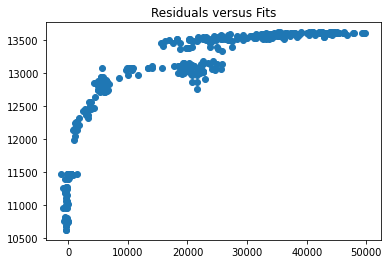

R^2 Score: 0.9978


In [29]:
plt.scatter(y_true.to_numpy() - y_pred,y_pred)
plt.title('Residuals versus Fits')
plt.show()

print(f'R^2 Score: {np.round(regr.score(X_train,y_train),4)}')


# https://statisticsbyjim.com/regression/interpret-r-squared-regression/

text = '''The data in the fitted line plot follow a very low noise relationship, and the R-squared is 98.5%,
 which seems fantastic. However, the regression line consistently under and over-predicts the data along
  the curve, which is bias. The Residuals versus Fits plot emphasizes this unwanted pattern. 
  An unbiased model has residuals that are randomly scattered around zero. Non-random residual patterns
   indicate a bad fit despite a high R2. Always check your residual plots!'''

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=465bb6a2-b771-4fe2-b2d2-aed723f7eb7d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>